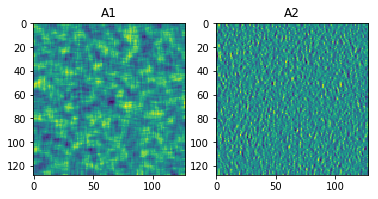

In [1]:
import numpy as np
from scipy.ndimage import convolve
from matplotlib import pyplot as plt
%matplotlib inline
channels = 5
hw = 128

# Create some Activation tensors
A1 = np.random.randn(channels,hw,hw)
A2 = np.random.rand(channels,hw,hw)

# make one low frequency  
filt = np.ones((3,6,6))
filt = filt / np.sum(filt)
A1 = convolve(A1,filt)
A1 = A1 - np.mean(A1)

# make one high frequency
filt = np.ones((2,3,3))
filt = filt / np.sum(filt)
filt[:,:,0] = filt[:,:,0]*(-1)
filt[:,:,1] = 0
A2 = convolve(A2,filt)
A2 = A2 - np.mean(A2)

# plot each tensor, average along channel
def show_active(A,title=''):
    plt.imshow(np.mean(A,0))
    plt.title(title)

plt.figure()
plt.subplot(1,2,1)
show_active(A1,'A1')
plt.subplot(1,2,2)
show_active(A2,'A2')

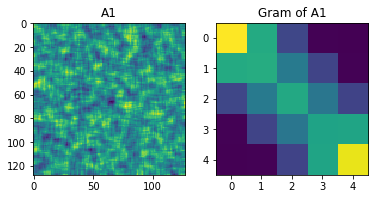

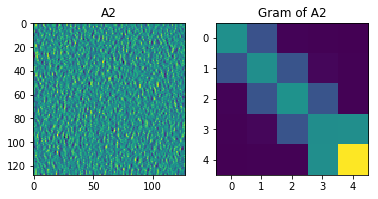

In [2]:
# calculate gram matrix (vectorized spatially) and show it
# for each activations
def gram(x):
    tmp = x.reshape((channels,hw*hw))
    return tmp @ tmp.T / (channels*hw*hw)

def show_gram(A,title=''):
    plt.figure()
    G = gram(A)
    plt.subplot(1,2,2)
    plt.imshow(G)
    plt.title('Gram of '+title)
    plt.subplot(1,2,1)
    show_active(A,title)
    

show_gram(A1,'A1')
show_gram(A2,'A2')

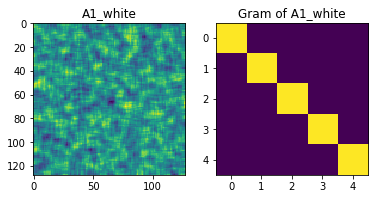

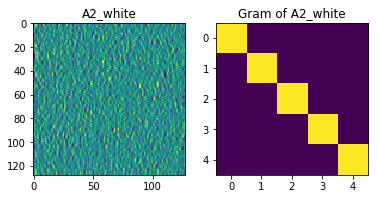

In [3]:
# apply whitening (get relevant SVD vectors)
def whiten(A):
    Avec = A.reshape((channels,hw*hw))
    u,s,vt = np.linalg.svd(Avec,full_matrices=False)
    A_white = (u @ vt).reshape((channels,hw,hw)) # no usage of the singular values here
    return A_white, (u, s, vt)
    
A1_white, A1SVD = whiten(A1)
A2_white, A2SVD = whiten(A2)

show_gram(A1_white,'A1_white')
show_gram(A2_white,'A2_white')


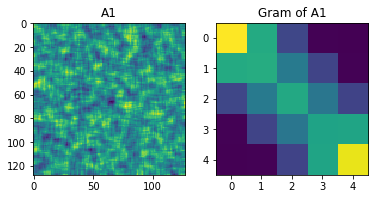

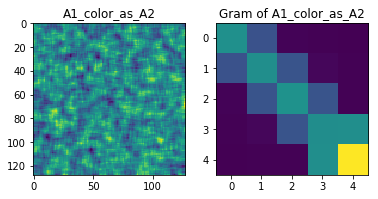

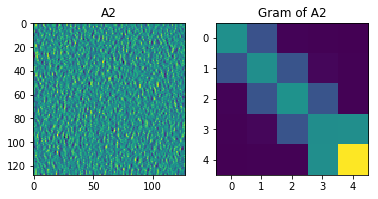

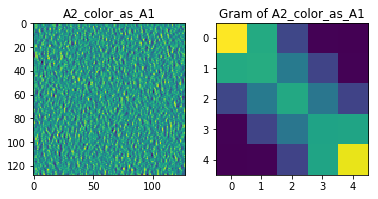

In [4]:
u1, s1, v1 = A1SVD
u2, s2, v2 = A2SVD

# Apply coloring
A1_color_as_A2 = (u2 @ np.diag(s2) @ v1).reshape((channels,hw,hw))
A2_color_as_A1 = (u1 @ np.diag(s1) @ v2).reshape((channels,hw,hw))

# show originals
# and colored versions
show_gram(A1,'A1')
show_gram(A1_color_as_A2,'A1_color_as_A2')

show_gram(A2,'A2')
show_gram(A2_color_as_A1,'A2_color_as_A1')